In [1]:
!pip install MDAnalysis
!pip install lipyphilic
!pip install hmmlearn

In [2]:
import pathlib
import pickle  # this library is used for saving the analysis objects to file
import joblib
import os

import numpy as np
import MDAnalysis as mda
import lipyphilic as lpp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.mixture
import hmmlearn.hmm
import matplotlib
import plotly.graph_objects as go

from tqdm.auto import tqdm


from lipyphilic.leaflets.assign_leaflets import AssignLeaflets, AssignCurvedLeaflets
from lipyphilic.analysis.order_parameter import SCC
from lipyphilic.analysis.z_angles import ZAngles
from lipyphilic.analysis.area_per_lipid import AreaPerLipid
from lipyphilic.analysis.z_positions import ZPositions
from lipyphilic.analysis.memb_thickness import MembThickness
from lipyphilic.plotting import JointDensity
from lipyphilic.analysis.z_thickness import ZThickness
from lipyphilic.plotting import ProjectionPlot
from lipyphilic.analysis.registration import Registration


from MDAnalysis.analysis.lineardensity import LinearDensity
from MDAnalysis.lib.mdamath  import normal
from MDAnalysis.lib.mdamath import norm
from MDAnalysis.lib.mdamath import angle
from MDAnalysis.lib.mdamath import make_whole


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vamos a ver con el perfil en Z

# Leemos el dataset de la densidad

In [3]:
# Read the CSV file with space separation and multiple spaces treated as one separator
new_df = pd.read_csv('./linear_density-OK.csv')

# If you need to clean up column names (remove extra spaces)
new_df.columns = new_df.columns.str.strip()

print(new_df.head())

         bin  DPPC         W  CHOL  Tail  Gli  Fosf  ZNPC  Lipid  DPPC_smooth  \
0 -67.641555   0.0  0.963729   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
1 -67.141555   0.0  0.959132   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
2 -66.641555   0.0  0.959044   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
3 -66.141555   0.0  0.958560   0.0   0.0  0.0   0.0   0.0    0.0          NaN   
4 -65.641555   0.0  0.958303   0.0   0.0  0.0   0.0   0.0    0.0          0.0   

   W_smooth  CHOL_smooth  Tail_smooth  Gli_smooth  Fosf_smooth  ZNPC_smooth  \
0       NaN          NaN          NaN         NaN          NaN          NaN   
1       NaN          NaN          NaN         NaN          NaN          NaN   
2       NaN          NaN          NaN         NaN          NaN          NaN   
3       NaN          NaN          NaN         NaN          NaN          NaN   
4  0.959754          0.0          0.0         0.0          0.0          0.0   

   Lipid_smooth  
0           NaN  
1 

In [4]:
## Hago un suavizado de los valores de densidad para que el grafico quede mejor:
# Apply rolling average with window size of 5 (change size as needed)
new_df['Lipid_smooth'] = new_df['Lipid'].rolling(window=5).mean()
new_df['DPPC_smooth'] = new_df['DPPC'].rolling(window=5).mean()
new_df['W_smooth'] = new_df['W'].rolling(window=5).mean()
new_df['CHOL_smooth'] = new_df['CHOL'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()
new_df['Gli_smooth'] = new_df['Gli'].rolling(window=5).mean()
new_df['Fosf_smooth'] = new_df['Fosf'].rolling(window=5).mean()
new_df['ZNPC_smooth'] = new_df['ZNPC'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()

# Leo el data Frame con la info de posiciones

In [5]:
# Read the CSV file with space separation and multiple spaces treated as one separator
df_positions = pd.read_csv('./z_positions-OK.csv')

# If you need to clean up column names (remove extra spaces)
df_positions.columns = df_positions.columns.str.strip()

print(df_positions.head())

   frames_z  average_z  average_P_down  average_P_up
0         0  25.919345       19.129058    -19.907968
1         1  21.548424       18.870744    -16.859790
2         2  27.861930       18.760635    -16.536690
3         3  28.776423       19.578615    -17.627433
4         4  25.915224       19.396753    -18.812775


# Leo el Dataframe con la informacion de los angulos

In [17]:
# Read the CSV file with space separation and multiple spaces treated as one separator
df_data_angles = pd.read_csv('./angles_data.csv')

# If you need to clean up column names (remove extra spaces)
df_data_angles.columns = df_data_angles.columns.str.strip()

print(df_data_angles.head())

   frames_z  transf_z_angle_deg   angles_2
0         0           51.738743  69.121309
1         1           42.253762  72.268587
2         2           43.389397  68.129143
3         3           55.067428  69.976478
4         4           47.992756  64.112125


In [18]:
transf_z_angle_deg = df_data_angles['transf_z_angle_deg']
angles_2 = df_data_angles['angles_2']

# Ahora vamos con los graficos

In [8]:
# Get the number of frames
num_frames_z = len(df_positions)
# Create the Plotly figure
fig = go.Figure()

# Add the ZnPc Z Position trace
fig.add_trace(go.Scatter(
    x=df_positions['frames_z'] / 20000,  # Divide x values by 10000
    y=df_positions['average_z'],
    mode='markers',
    name='ZnPc Z Position'
))

# Add the first Phosphates trace
fig.add_trace(go.Scatter(
    x=df_positions['frames_z'] / 20000,  # Divide x values by 10000
    y=df_positions['average_P_down'],
    mode='markers',
    name='Phosphates',
    marker=dict(color='purple')
))

# Add the second Phosphates trace without a legend label
fig.add_trace(go.Scatter(
    x=df_positions['frames_z'] / 20000,  # Divide x values by 10000
    y=df_positions['average_P_up'],
    mode='markers',
    showlegend=False,  # Hide this trace from the legend
    marker=dict(color='purple'),
))

# Add the dashed line for z=0
fig.add_shape(
    type="line",
    x0=0,
    x1=num_frames_z / 20000,  # Adjust x-axis scale
    y0=0,
    y1=0,
    line=dict(color="black", dash="dash"),
    name="Membrane Center"
)

# Update the layout of the plot
fig.update_layout(
    title="ZnPc z Position vs. Frame",
    xaxis_title="Time (μs)",  # Update axis label
    yaxis_title="z Position (Å)"
)

# Display the plot
fig.show()


# Hago el grafico de las posiciones con el programa seaborn

In [14]:
frames_z= df_positions['frames_z'] 
average_z= df_positions['average_z']
average_up_z= df_positions['average_P_up']
average_down_z= df_positions['average_P_down']
average_P_down=np.average(average_down_z)
average_P_up=np.average(average_up_z)

print(average_P_down, average_P_up)

19.091864654548623 -18.96041635950525


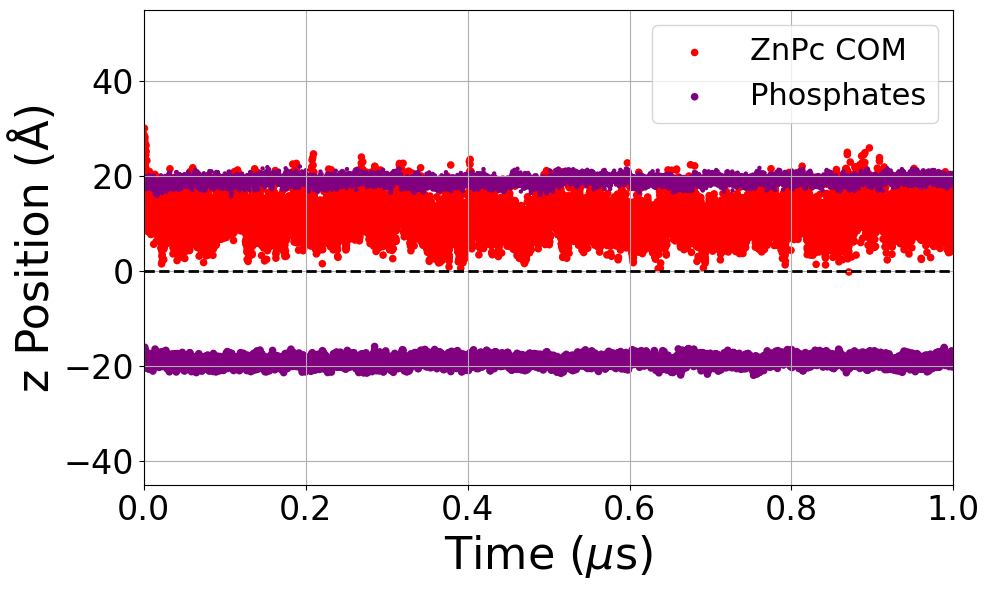

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: ZnPc ZN Position vs. Frame
fig1, ax1 = plt.subplots(figsize=(10, 6))  # Tamaño ajustado para el primer gráfico
sns.scatterplot(x=frames_z / 20000, y=average_z, ax=ax1, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_up_z, ax=ax1, marker='o', color='purple', label='Phosphates', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Configuración del primer gráfico
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=32)
ax1.set_ylabel('z Position (Å)', fontsize=32)
ax1.set_xlim(0, 1)  # Límite en x
ax1.set_ylim(-45, 55)  # Límite en y
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=24)

# Ubicacion de la cajita de label
ax1.legend(loc='upper right', fontsize=22)


# Mostrar el primer gráfico
plt.tight_layout()
plt.show()



# Hago el grafico combinado posicion y luego el conteo

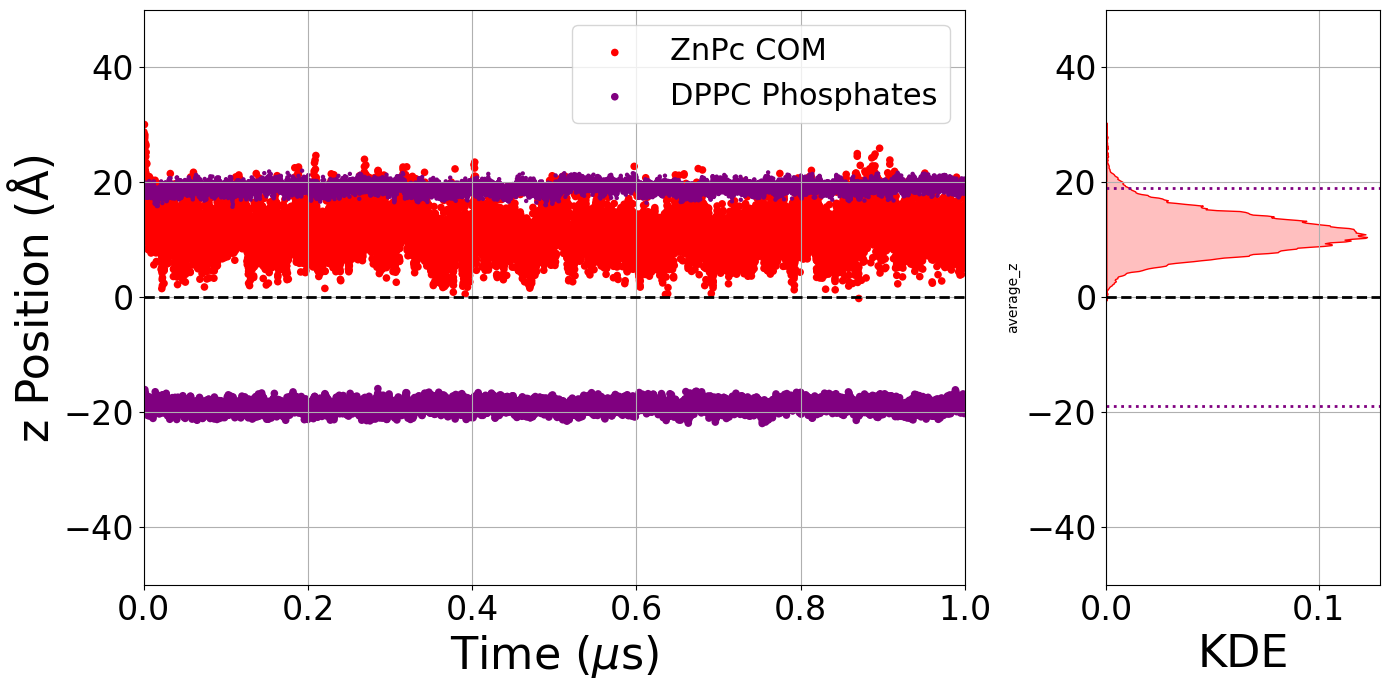

In [15]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [3, 1]})

# Plot the ZnPc ZN Position vs. frame using Seaborn
sns.scatterplot(x=frames_z / 20000, y=average_z, ax=ax1, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_up_z, ax=ax1, marker='o', color='purple', label='DPPC Phosphates', s=30, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Update x-axis label
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=32)
ax1.set_ylabel('z Position (Å)', fontsize=32)
ax1.grid(True)

# Increase tick label font size for ax1
ax1.tick_params(axis='both', which='major', labelsize=24)

# Plot the KDE of the average_z variable
sns.kdeplot(y=average_z, ax=ax2, fill=True, color='red', bw_adjust=0.25)
ax2.set_xlabel('KDE', fontsize=32)
ax2.grid(True)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax2.axhline(average_P_down, color='purple', linestyle='dotted', linewidth=2, label='DPPC Phosphates')
ax2.axhline(average_P_up, color='purple', linestyle='dotted', linewidth=2, label='DPPC Phosphates')

# Set x-axis limits
x_min = 0
x_max = 1
ax1.set_xlim(x_min, x_max)

# Set y-axis limits
y_min_2 = -50
y_max_2 = 50
ax1.set_ylim(y_min_2, y_max_2)
ax2.set_ylim(y_min_2, y_max_2)

# Increase tick label font size for ax2
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(fontsize=22)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#Si quisieras trabajar por fuera primero cargar el df_positions y luego realizar los graficos de estos

# Ahora el mismo grafico, pero con la densidad:

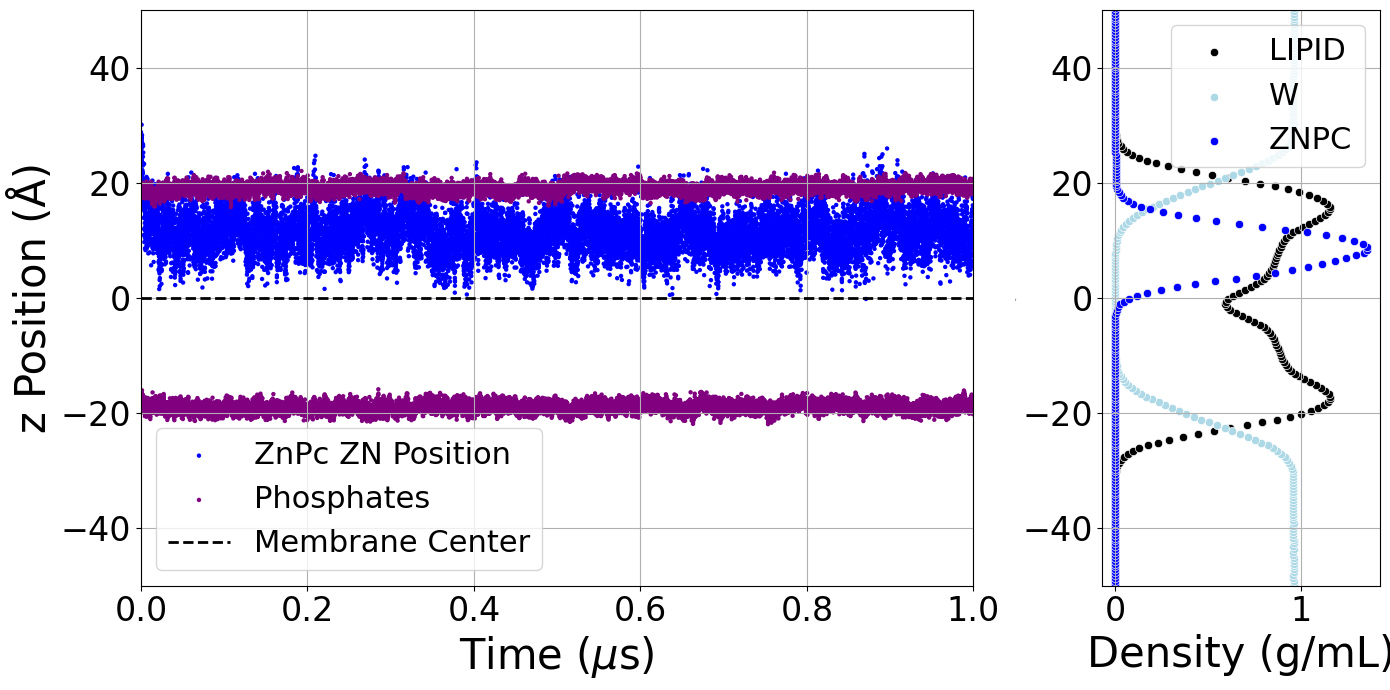

In [16]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [3, 1]})

# Plot the ZnPc ZN Position vs. frame using Seaborn
sns.scatterplot(x=frames_z / 20000, y=average_z, ax=ax1, marker='o', color='blue', label='ZnPc ZN Position', s=10, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_up_z, ax=ax1, marker='o', color='purple', label='Phosphates', s=10, edgecolor='none')
sns.scatterplot(x=frames_z / 20000, y=average_down_z, ax=ax1, marker='o', color='purple', s=10, edgecolor='none')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Membrane Center')

# Update x-axis label
ax1.set_xlabel(r"Time ($\mu$s)", fontsize=30)
ax1.set_ylabel('z Position (Å)', fontsize=30)
ax1.grid(True)

# Increase tick label font size for ax1
ax1.tick_params(axis='both', which='major', labelsize=24)


# Plot the smoothed lines with shading
sns.scatterplot(y='bin', x='Lipid_smooth', data=new_df, label='LIPID', color='black',ax=ax2)
sns.scatterplot(y='bin', x='W_smooth', data=new_df, label='W', color='lightblue',ax=ax2)
sns.scatterplot(y='bin', x=new_df['ZNPC_smooth'] * 50, data=new_df, label='ZNPC', color='blue',ax=ax2)



# Add labels and title
ax2.set_ylabel('z(nm)',fontsize=0.001)
ax2.set_xlabel('Density (g/mL)',fontsize=30)
#ax2.set_title('Linear Density Profile with Moving Average Smoothing')

# Add legend
ax2.legend()
ax2.grid(True)

ax2.legend(loc='best', fontsize=22)

# Show the plot
#ax2.show()


# Set x-axis limits
x_min = 0
x_max = 1
ax1.set_xlim(x_min, x_max)

# Set y-axis limits
y_min_2 = -50
y_max_2 = 50
ax1.set_ylim(y_min_2, y_max_2)
ax2.set_ylim(y_min_2, y_max_2)

# Increase tick label font size for ax2
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.legend(fontsize=22)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Graficos de distribucion de Angulos

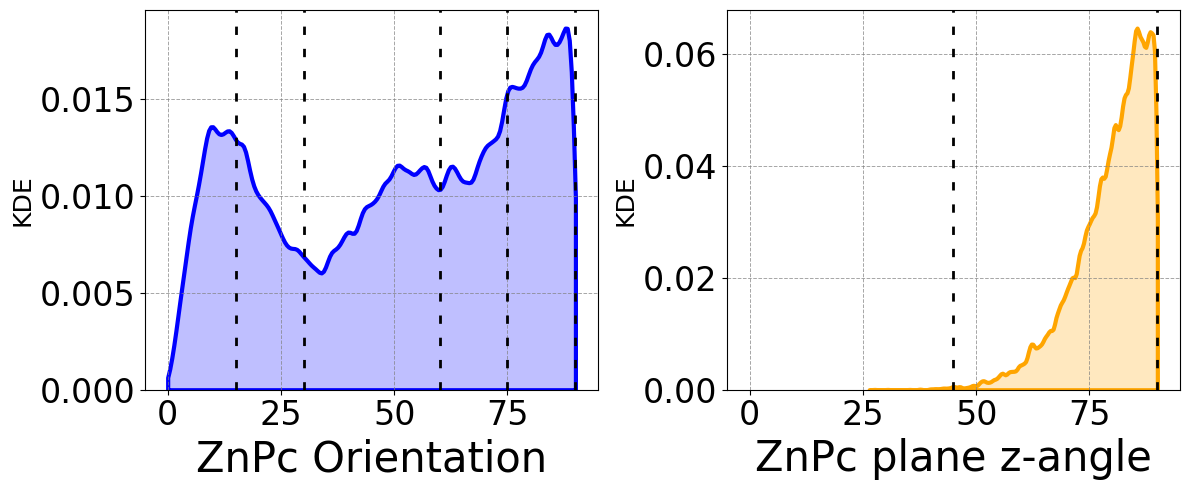

In [19]:
# Create the figure and axes with the specified aspect ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})

# Plot the KDE of the first dataset with transposed axes on ax1
sns.kdeplot(x=transf_z_angle_deg, ax=ax1, fill=True, color='blue', bw_adjust=0.25, clip=(0, 90), linewidth=3.0)
ax1.set_ylabel('KDE', fontsize=18)  # Transposed to y-axis label
ax1.grid(True)
ax1.axvline(x=15, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label='conf limits')  # Vertical lines
ax1.axvline(x=30, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=60, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=75, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.axvline(x=90, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

# Set x-axis limits for ax1
x_min_1 = -5
x_max_1 = 95
ax1.set_xlim(x_min_1, x_max_1)

# Plot the KDE of the second dataset with transposed axes on ax2
sns.kdeplot(x=angles_2, ax=ax2, fill=True, color='orange', bw_adjust=0.35, clip=(0, 90), linewidth=3.0)
ax2.set_ylabel('KDE', fontsize=18)  # Transposed to y-axis label
ax2.grid(True)
ax2.axvline(x=45, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label='conf limits')  # Vertical lines
ax2.axvline(x=90, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

# Set x-axis limits for ax2
x_min_2 = -5
x_max_2 = 95
ax2.set_xlim(x_min_2, x_max_2)


ax2.set_xlabel('ZnPc plane z-angle',fontsize=30)
ax1.set_xlabel('ZnPc Orientation',fontsize=30)

# Parametros de los graficos
ax1.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


# Esta es otra opcion del grafico de distribuciones

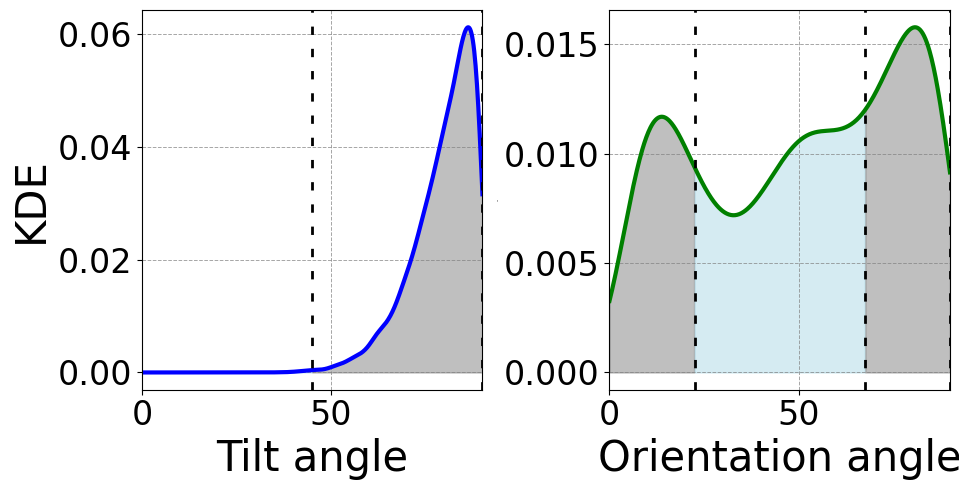

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Compute KDE data manually
def compute_kde(data, bw_adjust, x_range):
    kde = gaussian_kde(data, bw_method=bw_adjust)
    x = np.linspace(x_range[0], x_range[1], 500)  # Create 500 points in the specified range
    y = kde(x)
    return x, y

# Define datasets and KDE parameters
x1_data, y1_data = compute_kde(transf_z_angle_deg, bw_adjust=0.2, x_range=(0, 90))
x2_data, y2_data = compute_kde(angles_2, bw_adjust=0.2, x_range=(0, 90))

# Create the figure and axes
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(9.7, 5), gridspec_kw={'width_ratios': [1, 1]})

# --- Plot the Left Graph ---
ax1.plot(x1_data, y1_data, color='green', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 0) & (x1_data <= 22.5), color='gray', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 22.5) & (x1_data <= 67.5), color='lightblue', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 67.5), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [22.5, 67.5, 90]:
    ax1.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.set_ylabel('KDE', fontsize=0)
ax1.set_xlabel('Orientation angle', fontsize=30)
ax1.set_xlim(-5, 95)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# --- Plot the Right Graph ---
ax2.plot(x2_data, y2_data, color='blue', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data < 45), color='lightblue', alpha=0.5)
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data >= 45), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [45, 90]:
    ax2.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax2.set_ylabel('KDE', fontsize=30)
ax2.set_xlabel('Tilt angle', fontsize=30)
ax2.set_xlim(-5, 95)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

# Set y-axis limits
x_min_a = 0
x_max_a = 90
ax1.set_xlim(x_min_a, x_max_a)
ax2.set_xlim(x_min_a, x_max_a)



# Adjust layout and show the plots
ax1.tick_params(axis='both', which='major', labelsize=24)
ax2.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


# Grafico incluyendo toda la informacion

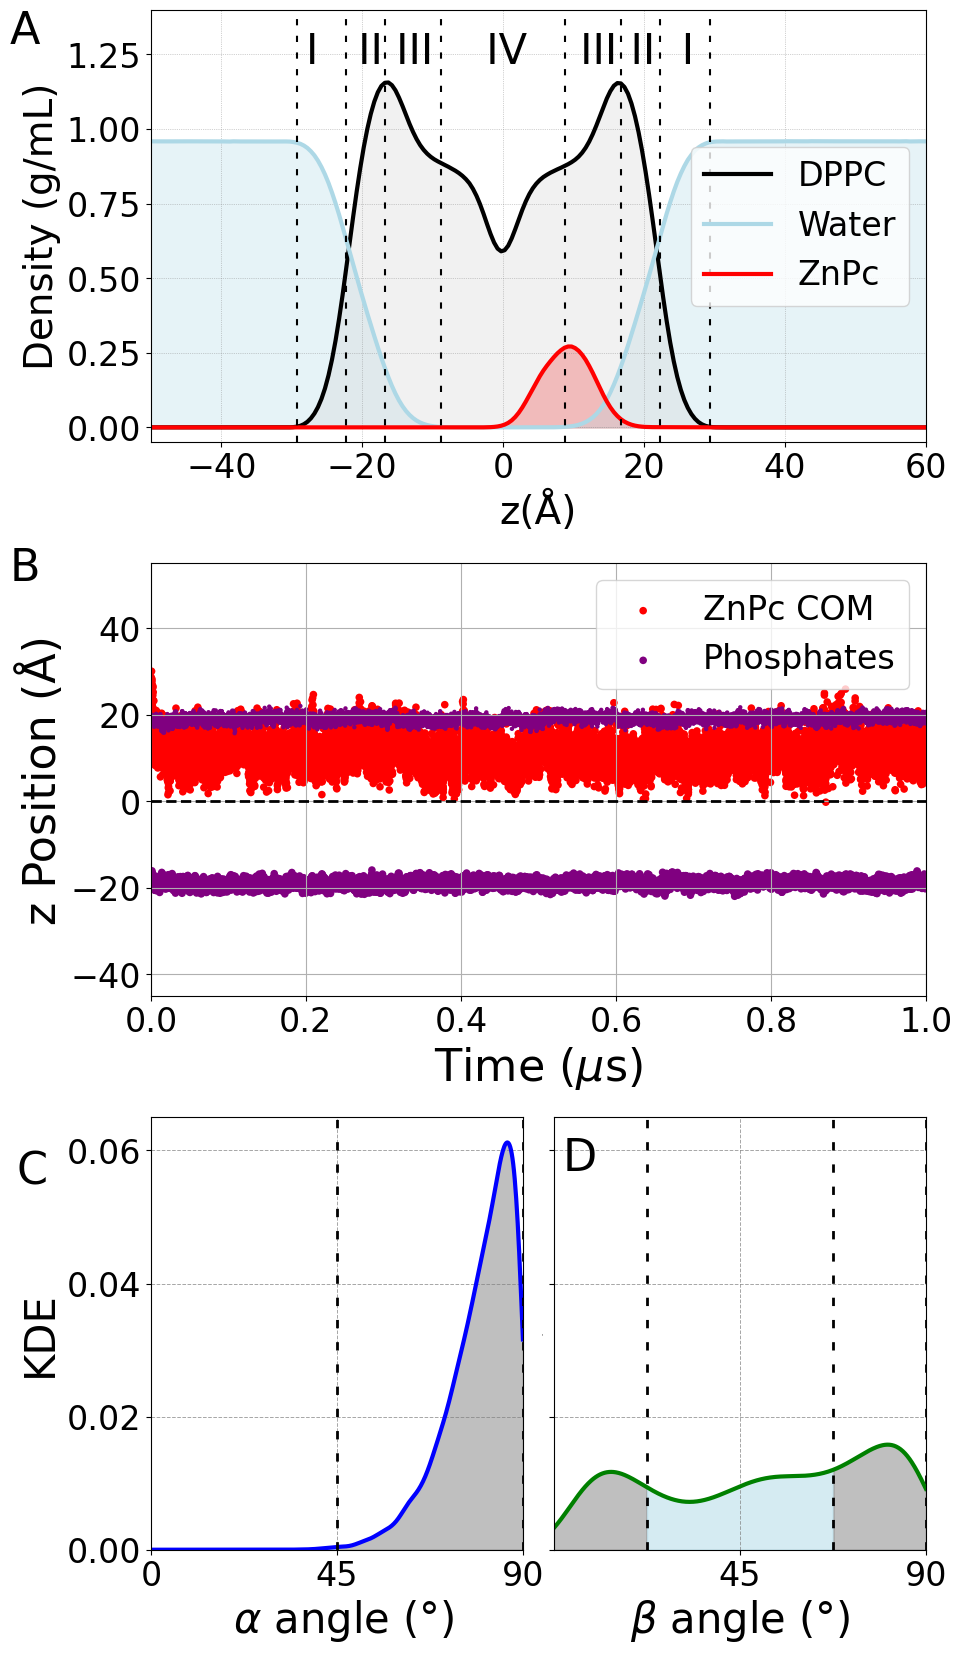

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

# Assume the necessary data (`new_df`, `Offset`, etc.) is already prepared.

# Create a figure and 3 subplots (vertically stacked)
fig, axes = plt.subplots(3, 1, figsize=(10, 20), gridspec_kw={'hspace': 0.28})  # Adjust hspace for spacing

# --- Plot 1 ---
Offset = -0.85

sns.lineplot(ax=axes[0],x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(ax=axes[0], x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
sns.lineplot(ax=axes[0], x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 10, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
axes[0].fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 10, color='red', alpha=0.3)
# Fill the area under ZNPC_smooth curve
axes[0].fill_between(new_df['bin'] - Offset, new_df['W_smooth'], color='lightblue', alpha=0.3)
axes[0].fill_between(new_df['bin'] - Offset, new_df['Lipid_smooth'], color='lightgray', alpha=0.3)



# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed


# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    axes[0].axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    axes[0].axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    axes[0].axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    axes[0].axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

axes[0].axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
axes[0].axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
axes[0].set_xlabel('z(Å)',fontsize=28)
axes[0].set_ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
axes[0].legend(loc='center right', fontsize=24)
axes[0].set_xlim(-50, 60)
axes[0].set_ylim(-0.05, 1.40)
axes[0].tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

# Add the text with the regions info
axes[0].text(
    -28, 1.22,  # x, y coordinates of the text in data units
    'I   II III    IV    III II  I',  # The text to display
    fontsize=30,  # Font size of the text
    bbox=dict(facecolor='white', alpha=0.0,edgecolor='white' )  # Text box style
)
# --- Plot 2 ---

sns.scatterplot(ax=axes[1], x=frames_z / 20000, y=average_z, marker='o', color='red', label='ZnPc COM', s=30, edgecolor='none')
sns.scatterplot(ax=axes[1],x=frames_z / 20000, y=average_up_z, marker='o', color='purple', label='Phosphates', s=30, edgecolor='none')
sns.scatterplot(ax=axes[1],x=frames_z / 20000, y=average_down_z, marker='o', color='purple', s=10, edgecolor='none')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)

# Configuración del primer gráfico
axes[1].set_xlabel(r"Time ($\mu$s)", fontsize=32)
axes[1].set_ylabel('z Position (Å)', fontsize=32)
axes[1].set_xlim(0, 1)  # Límite en x
axes[1].set_ylim(-45, 55)  # Límite en y
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=24)

# Ubicacion de la cajita de label
axes[1].legend(loc='upper right', fontsize=24)

#################

# --- Plot 3: Two subplots side-by-side ---
# Divide the third subplot into two sub-axes
#axes[2].remove()
# --- Plot 3: Two subplots side-by-side ---
# Divide the third subplot into two sub-axes

axes[2].axis('off')


# Compute KDE data manually
def compute_kde(data, bw_adjust, x_range):
    kde = gaussian_kde(data, bw_method=bw_adjust)
    x = np.linspace(x_range[0], x_range[1], 500)  # Create 500 points in the specified range
    y = kde(x)
    return x, y

# Define datasets and KDE parameters
x1_data, y1_data = compute_kde(transf_z_angle_deg, bw_adjust=0.2, x_range=(0, 90))
x2_data, y2_data = compute_kde(angles_2, bw_adjust=0.2, x_range=(0, 90))

# Create the figure and axes
ax2 = axes[2].inset_axes([0.0, 0.0, 0.48, 1.0])  # [x, y, width, height]
ax1 = axes[2].inset_axes([0.52, 0.0, 0.48, 1.0])
# --- Plot the Left Graph ---
ax1.plot(x1_data, y1_data, color='green', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 0) & (x1_data <= 22.5), color='gray', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 22.5) & (x1_data <= 67.5), color='lightblue', alpha=0.5)
ax1.fill_between(x1_data, 0, y1_data, where=(x1_data >= 67.5), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [22.5, 67.5, 90]:
    ax1.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax1.set_ylabel('KDE', fontsize=0)
ax1.set_xlabel(r'$\beta$ angle (°)', fontsize=30)  # Combining text and Greek letter
#ax1.set_xlabel('$\beta$(°)', fontsize=30)
ax1.set_xlim(-5, 95)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax1.set_xticks([45, 90])  # Set tick positions

# --- Plot the Right Graph ---
ax2.plot(x2_data, y2_data, color='blue', linewidth=3.0)  # Plot the KDE curve

# Si comento estas lineas no queda pintado
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data < 45), color='lightblue', alpha=0.5)
ax2.fill_between(x2_data, 0, y2_data, where=(x2_data >= 45), color='gray', alpha=0.5)

# Add vertical lines and labels
for value in [45, 90]:
    ax2.axvline(x=value, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
ax2.set_ylabel('KDE', fontsize=30)
ax2.set_xlabel(r' $\alpha$ angle (°)', fontsize=30)  # Combining text and Greek letter
#ax2.set_xlabel('$\alpha$(°)', fontsize=30)
ax2.set_xlim(-5, 95)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax2.set_xticks([0, 45, 90])  # Set tick positions

# Set x-axis limits
x_min_a = 0
x_max_a = 90
ax1.set_xlim(x_min_a, x_max_a)
ax2.set_xlim(x_min_a, x_max_a)

# Set y-axis limits
y_min_a = 0
y_max_a = 0.065
ax1.set_ylim(y_min_a, y_max_a)
ax2.set_ylim(y_min_a, y_max_a)


# Adjust layout and show the plots
ax2.tick_params(axis='both', which='major', labelsize=24)
ax1.tick_params(axis='x', which='major', labelsize=24)
ax1.tick_params(axis='y', right=False, which='major', labelsize=24,labelright=False,labelleft=False)
#ax1.yaxis.set_label_position("right")

# Pongo el label a cada grafico (A, B, C, D)

axes[0].text(
    -70, 1.4,  # Coordenadas relativas (x, y) de la figura
    'A',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

axes[0].text(
    -70, -0.4,  # Coordenadas relativas (x, y) de la figura
    'B',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

ax1.text(
    -130, 0.06,  # Coordenadas relativas (x, y) de la figura
    'C',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

ax1.text(
    2, 0.062,  # Coordenadas relativas (x, y) de la figura
    'D',  # Texto a mostrar
    fontsize=32,  # Tamaño de fuente
    va='top',  # Alineación vertical
    ha='left'  # Alineación horizontal
)

# Adjust layout and save the combined figure
#plt.tight_layout()
plt.savefig('Figure-3-znpc-dppc.png', dpi=300)
plt.show()
